# Model Processing

## Imports & General Settings 

In [14]:
import unittest
import os
import sys
import time
import pathlib

import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
import PIL
from tqdm.notebook import trange, tqdm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve, roc_auc_score
from matplotlib import pyplot
from scipy.signal import resample


# Our imports
from data import WaveletTransform, AFECGDataset, SecondDataset, WrapperDataset
import dsp
from model.blocks import ConvNet, BRNN, SoftmaxAttention
from model.baseline import Baseline
from training import train, test
import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
testCase = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Dataset creation

In [23]:
dataset_name = 'afdb'
dataset = AFECGDataset(dataset_name, '../data/afdb/', wavelet=WaveletTransform())

In [8]:
dataset.load('./temp/' + dataset_name)

Preprocessing examples: 0it [00:00, ?it/s]

Preparing 61 samples


/Users/miki/PycharmProjects/final_project_cs236781/src/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavelets.append(torch.tensor(sw))
Preprocessing examples: 61it [01:21,  1.33s/it]


In [9]:
images_per_sample = 20
total_data_size = len(dataset)
print("Total data size: ", total_data_size)
print("Samples with AF: ", dataset.labels.sum().item())

Total data size:  61
Samples with AF:  4


##  Wavelet Transform

Has AF:  Yes


ValueError: only one element tensors can be converted to Python scalars

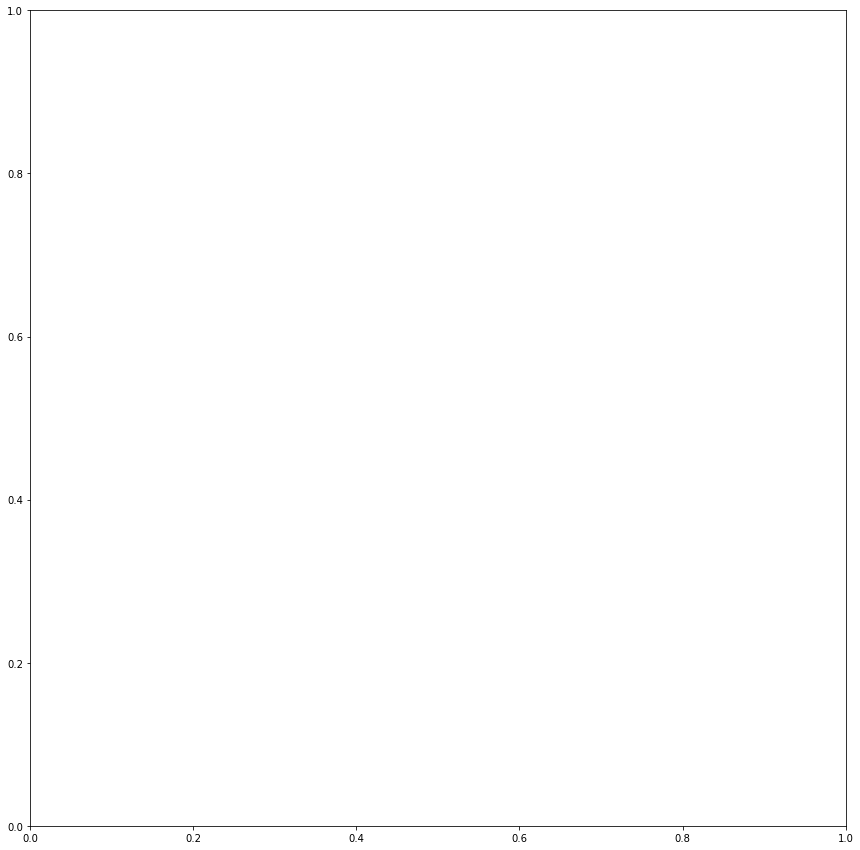

In [22]:
powers, label = dataset[0]
print('Has AF: ', 'Yes' if label == 1 else 'No')

signal = resample(powers[0], 7000)
plt.figure(figsize=(15, 15))
plt.imshow(signal)
plt.show()

Has AF:  No


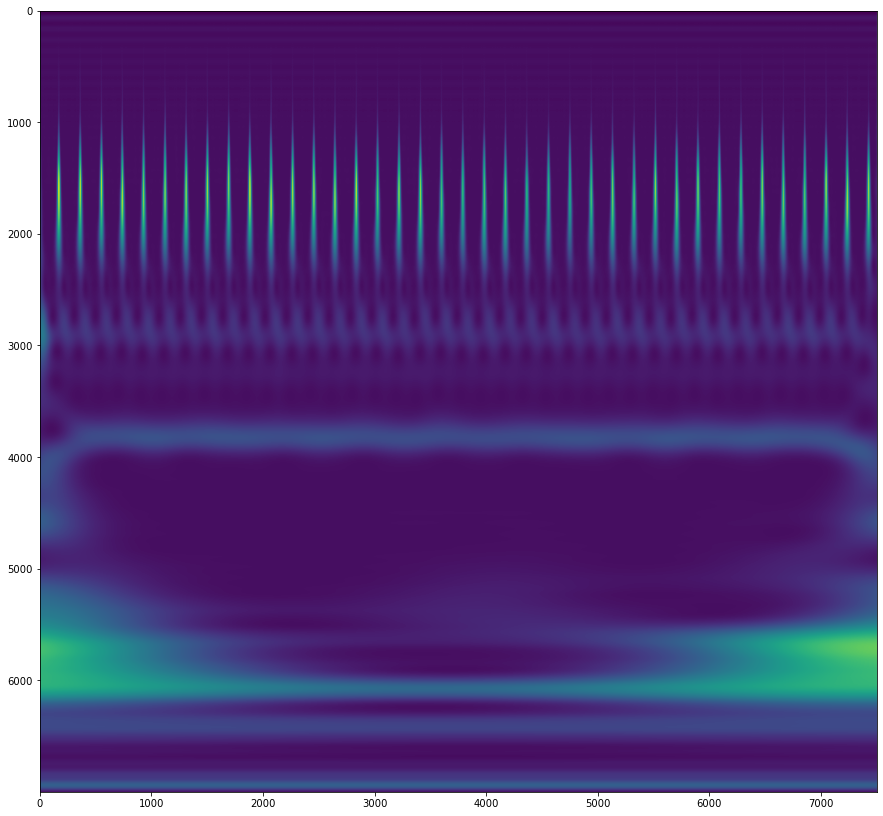

In [21]:
powers, label = dataset[3]
print('Has AF: ', 'Yes' if label == 1 else 'No')

signal = resample(powers[0], 7000)
plt.figure(figsize=(15, 15))
plt.imshow(signal)
plt.show()

In [ ]:
# Total data size is 1397
# You can choose the data size 
data_size = len(dataset)

## BRNN

In [ ]:
display(BRNN(50, 50, images_per_sample))

## Attention

Notations:

* $Y = \left[ y_1, \ldots, y_T \right]$ – the input matrix of size $\left( N \times T \right)$, where $N$ is the number of features in a single output vector of the BRNN

* $w_\mathrm{att}$ – The parameters of the attention model, of size $\left( N \times 1 \right)$, where $N$ is the number of features in a single output vector of the BRNN

* $\alpha$ – The attention weights, given as $\alpha = \mathrm{softmax} \left( w_\mathrm{att}^T Y \right)$. This is an element-wise softmax, where the output size of $\alpha$ is $\left( 1 \times T \right)$

* $h_\mathrm{att}$ – Output of the attention mechanism, given by $h_\mathrm{att} = Y \alpha^T$, of size $\left( N \times 1 \right)$, i.e. a vector of $N$ features.

## Training

In [ ]:
model = Baseline()

### CNN

In [ ]:
heldout = int(len(dataset) * 0.2)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - heldout, heldout])

In [ ]:
test_labels = dataset.labels[test_dataset.indices]
print(type(dataset.samples))
test_samples = dataset.samples[test_dataset.indices]

print(test_labels[test_labels == 1].shape)
print(test_samples[test_labels == 1].shape)

In [ ]:
data_pos = dataset.samples[dataset.labels == 1]
data_neg = dataset.samples[dataset.labels == 0]
labels_pos = dataset.labels[dataset.labels == 1]
labels_neg = dataset.labels[dataset.labels == 0]

### Baseline

In [ ]:
model = Baseline()

# positive_scale = len(data_neg) // len(data_pos)
# class_weights = torch.tensor([
#     positive_scale,
#     1.0
# ])

config = dict(
    num_workers=8,
    batch_size=90,
    learning_rate=0.01,
    weight_decay=0.001,
    num_epochs=4,
    is_notebook=True
)

train(model, train_dataset, config)

## Testing

In [ ]:
y_true = dataset.labels[test_dataset.indices]
y_pred, test_acc = test(model, test_dataset, config)

In [ ]:
from sklearn import metrics
results = pd.DataFrame(classification_report(y_true, y_pred, zero_division=0, output_dict=True)).transpose()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
auc_score = metrics.auc(fpr, tpr)

In [ ]:
display(results)
print("Specificity:", specificity)
print("AUC:", auc_score)

In [ ]:
lr_auc = roc_auc_score(y_true, y_pred)
print('ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Baseline model')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [ ]:
pr_auc = average_precision_score(y_true, y_pred)
print("PR AUC:", specificity)